In [37]:
#chack for updated files\n,
%load_ext autoreload
%autoreload 2
#import packages
from __future__ import division

%load_ext line_profiler
import numpy as np
import glob, json
import pickle
import os as os_pack
import matplotlib.pyplot as plt
import corner
#%matplotlib inline\n",
%config InlineBackend.figure_format = 'retina'
import healpy as hp
import os, glob, json, pickle
import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg as sl
import enterprise
from enterprise.pulsar import Pulsar
import enterprise.signals.parameter as parameter
from enterprise.signals import utils
from enterprise.signals import signal_base
from enterprise.signals import selections
from enterprise.signals.selections import Selection
from enterprise.signals import white_signals
from enterprise.signals import gp_signals
from enterprise.signals import deterministic_signals
import enterprise.constants as const
from enterprise_extensions import blocks
from enterprise_extensions import models as ee_models
from enterprise_extensions import model_utils as ee_model_utils
from enterprise_extensions import model_orfs
from enterprise_extensions.frequentist import optimal_statistic as opt_stat
from enterprise_extensions import sampler as ee_sampler
from enterprise.signals.signal_base import LogLikelihood
import enterprise_wavelets as models
from enterprise.signals.deterministic_signals import Deterministic
from enterprise.signals.parameter import function
from la_forge.core import Core
from la_forge.diagnostics import plot_chains
from la_forge import rednoise
import la_forge
import corner
from PTMCMCSampler.PTMCMCSampler import PTSampler as ptmcmc
import re
#style
    
#import Fast_Burst_likelihood as FB

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [2]:
#Loading in pickle and noise files
pint_pickle = '/home/reyna/OS_15yr/15yr_data/v1p1_de440_pint_bipm2019.pkl'
noise_file = '/home/reyna/OS_15yr/15yr_data/v1p1_wn_dict.json'
#psrlist = np.loadtxt('/home/reyna/15yr_v1p0/15yr_v1-20211001T235643Z-001/15yr_v1/psrlist_15yr_pint.txt', dtype = str)
with open(noise_file, 'r') as h:
    noise_params = json.load(h)
with open(pint_pickle,'rb') as f:
    allpsrs = pickle.load(f)
psrs = []
for ii,p in enumerate(allpsrs):
    psrs.append(p)
#Temporary to get code to not crash
psrs = psrs[0:]
psrlist = [psr.name for psr in psrs]
print(psrlist)
for i in range(len(psrs)):
    print((max(psrs[i].toas) - min(psrs[i].toas))/(3.17*10**(7)))

['B1855+09', 'B1937+21', 'B1953+29', 'J0023+0923', 'J0030+0451', 'J0340+4130', 'J0406+3039', 'J0437-4715', 'J0509+0856', 'J0557+1551', 'J0605+3757', 'J0610-2100', 'J0613-0200', 'J0636+5128', 'J0645+5158', 'J0709+0458', 'J0740+6620', 'J0931-1902', 'J1012+5307', 'J1012-4235', 'J1022+1001', 'J1024-0719', 'J1125+7819', 'J1312+0051', 'J1453+1902', 'J1455-3330', 'J1600-3053', 'J1614-2230', 'J1630+3734', 'J1640+2224', 'J1643-1224', 'J1705-1903', 'J1713+0747', 'J1719-1438', 'J1730-2304', 'J1738+0333', 'J1741+1351', 'J1744-1134', 'J1745+1017', 'J1747-4036', 'J1751-2857', 'J1802-2124', 'J1811-2405', 'J1832-0836', 'J1843-1113', 'J1853+1303', 'J1903+0327', 'J1909-3744', 'J1910+1256', 'J1911+1347', 'J1918-0642', 'J1923+2515', 'J1944+0907', 'J1946+3417', 'J2010-1323', 'J2017+0603', 'J2033+1734', 'J2043+1711', 'J2124-3358', 'J2145-0750', 'J2214+3000', 'J2229+2643', 'J2234+0611', 'J2234+0944', 'J2302+4442', 'J2317+1439', 'J2322+2057']
15.515060297068947
15.802872967471835
11.08458774068679
8.975425297

In [3]:
glitches = []
N_glitches = 5
for i in range(N_glitches):
    log10_f0 = parameter.Uniform(np.log10(3.5e-9), np.log10(1e-7))("Glitch_"+str(i)+'_'+'log10_f0')
    phase0 = parameter.Uniform(0, 2*np.pi)("Glitch_"+str(i)+'_'+'phase0')
    tau = parameter.Uniform(0.2, 5)("Glitch_"+str(i)+'_'+'tau')
    t0 = parameter.Uniform(0.0, 10.0)("Glitch_"+str(i)+'_'+'t0')
    psr_idx = parameter.Uniform(-0.5, len(psrs)-0.5)("Glitch_"+str(i)+'_'+'psr_idx')
    log10_h = parameter.LinearExp(-10.5, -9)("Glitch_"+str(i)+'_'+'log10_h')
    glitch_wf = models.glitch_delay(log10_h = log10_h, tau = tau, log10_f0 = log10_f0, t0 = t0, phase0 = phase0, tref=53000*86400,
                                            psr_float_idx = psr_idx, pulsars=psrs)
    glitches.append(deterministic_signals.Deterministic(glitch_wf, name='Glitch'+str(i) ))

In [4]:
#wavelet models
wavelets = [] #added "wavelet_" to names to help with seperation
N_wavelets = 5
for i in range(N_wavelets):
    log10_f0 = parameter.Uniform(np.log10(3.5e-9), np.log10(1e-7))("wavelet_"+str(i)+'_'+'log10_f0')
    cos_gwtheta = parameter.Uniform(-1, 1)("wavelet_"+str(i)+'_'+'cos_gwtheta')
    gwphi = parameter.Uniform(0, 2*np.pi)("wavelet_"+str(i)+'_'+'gwphi')
    psi = parameter.Uniform(0, np.pi)("wavelet_"+str(i)+'_'+'gw_psi')
    phase0 = parameter.Uniform(0, 2*np.pi)("wavelet_"+str(i)+'_'+'phase0')
    phase0_cross = parameter.Uniform(0, 2*np.pi)("wavelet_"+str(i)+'_'+'phase0_cross')
    tau = parameter.Uniform(0.2, 5)("wavelet_"+str(i)+'_'+'tau')
    t0 = parameter.Uniform(0.0, 10.0)("wavelet_"+str(i)+'_'+'t0')
    log10_h = parameter.LinearExp(-18,-11)("wavelet_"+str(i)+'_'+'log10_h')
    log10_h_cross = parameter.LinearExp(-18,-11)("wavelet_"+str(i)+'_'+'log10_h_cross')
    wavelet_wf = models.wavelet_delay(cos_gwtheta=cos_gwtheta, gwphi=gwphi, log10_h = log10_h, log10_h2=log10_h_cross,
                                      tau = tau, log10_f0 = log10_f0, t0 = t0, phase0 = phase0, phase02=phase0_cross,
                                      epsilon = None, psi=psi, tref=53000*86400)
    wavelets.append(deterministic_signals.Deterministic(wavelet_wf, name='wavelet'+str(i)))

In [65]:
tm = gp_signals.TimingModel(use_svd=True)
wn = blocks.white_noise_block(vary=False, inc_ecorr=False)

Tspan = ee_model_utils.get_tspan(psrs)
rn = blocks.red_noise_block(psd='powerlaw', prior = 'log-uniform', Tspan=Tspan, components = 30)

#s = base_model
s = tm + wn + rn
for i in range(N_glitches):
    s += glitches[i]
for j in range(N_wavelets):
    s += wavelets[j]
model = []
for p in psrs:
    model.append(s(p))
with open(noise_file, 'r') as fp:
    noisedict = json.load(fp)
    pta = signal_base.PTA(model)
    pta.set_default_params(noisedict)

In [70]:
d0_15y = parameter.sample(pta.params)
x0_15y = np.array([d0_15y[par.name] for par in pta.params])

In [7]:
d0_15y;

In [29]:
d0_sample = parameter.sample(pta.params)

In [30]:
d0_15y_2 = {'Glitch_0_log10_f0': d0_15y['Glitch_0_log10_f0'],
         'Glitch_0_log10_h': d0_sample['Glitch_0_log10_h'],
         'Glitch_0_phase0': d0_sample['Glitch_0_phase0'],
         'Glitch_0_psr_idx': d0_15y['Glitch_0_psr_idx'],
         'Glitch_0_t0': d0_15y['Glitch_0_t0'],
         'Glitch_0_tau': d0_15y['Glitch_0_tau'],
         'Glitch_1_log10_f0': d0_15y['Glitch_1_log10_f0'],
         'Glitch_1_log10_h': d0_sample['Glitch_1_log10_h'],
         'Glitch_1_phase0': d0_sample['Glitch_1_phase0'],
         'Glitch_1_psr_idx':d0_15y['Glitch_1_psr_idx'],
         'Glitch_1_t0': d0_15y['Glitch_1_t0'],
         'Glitch_1_tau': d0_15y['Glitch_1_tau'],
         'Glitch_2_log10_f0': d0_15y['Glitch_2_log10_f0'],
         'Glitch_2_log10_h': d0_sample['Glitch_2_log10_h'],
         'Glitch_2_phase0': d0_sample['Glitch_2_phase0'],
         'Glitch_2_psr_idx': d0_15y['Glitch_2_psr_idx'],
         'Glitch_2_t0': d0_15y['Glitch_2_t0'],
         'Glitch_2_tau': d0_15y['Glitch_2_tau'],
         'Glitch_3_log10_f0': d0_15y['Glitch_3_log10_f0'],
         'Glitch_3_log10_h': d0_sample['Glitch_3_log10_h'],
         'Glitch_3_phase0': d0_sample['Glitch_3_phase0'],
         'Glitch_3_psr_idx': d0_15y['Glitch_3_psr_idx'],
         'Glitch_3_t0': d0_15y['Glitch_3_t0'],
         'Glitch_3_tau': d0_15y['Glitch_3_tau'],
         'Glitch_4_log10_f0': d0_15y['Glitch_4_log10_f0'],
         'Glitch_4_log10_h': d0_sample['Glitch_4_log10_h'],
         'Glitch_4_phase0': d0_sample['Glitch_4_phase0'],
         'Glitch_4_psr_idx': d0_15y['Glitch_4_psr_idx'],
         'Glitch_4_t0': d0_15y['Glitch_4_t0'],
         'Glitch_4_tau': d0_15y['Glitch_4_tau'],
         'wavelet_0_cos_gwtheta': d0_sample['wavelet_0_cos_gwtheta'],
         'wavelet_0_gw_psi': d0_sample['wavelet_0_gw_psi'],
         'wavelet_0_gwphi': d0_sample['wavelet_0_gwphi'],
         'wavelet_0_log10_f0': d0_15y['wavelet_0_log10_f0'],
         'wavelet_0_log10_h': d0_sample['wavelet_0_log10_h'],
         'wavelet_0_log10_h_cross': d0_sample['wavelet_0_log10_h_cross'],
         'wavelet_0_phase0': d0_sample['wavelet_0_phase0'],
         'wavelet_0_phase0_cross': d0_sample['wavelet_0_phase0_cross'],
         'wavelet_0_t0': d0_15y['wavelet_0_t0'],
         'wavelet_0_tau': d0_15y['wavelet_0_tau'],
         'wavelet_1_cos_gwtheta': d0_sample['wavelet_1_cos_gwtheta'],
         'wavelet_1_gw_psi': d0_sample['wavelet_1_gw_psi'],
         'wavelet_1_gwphi': d0_sample['wavelet_1_gwphi'],
         'wavelet_1_log10_f0': d0_15y['wavelet_1_log10_f0'],
         'wavelet_1_log10_h': d0_sample['wavelet_1_log10_h'],
         'wavelet_1_log10_h_cross': d0_sample['wavelet_1_log10_h_cross'],
         'wavelet_1_phase0': d0_sample['wavelet_1_phase0'],
         'wavelet_1_phase0_cross': d0_sample['wavelet_1_phase0_cross'],
         'wavelet_1_t0': d0_15y['wavelet_1_t0'],
         'wavelet_1_tau':d0_15y['wavelet_1_tau'],
         'wavelet_2_cos_gwtheta': d0_sample['wavelet_2_cos_gwtheta'],
         'wavelet_2_gw_psi': d0_sample['wavelet_2_gw_psi'],
         'wavelet_2_gwphi': d0_sample['wavelet_2_gwphi'],
         'wavelet_2_log10_f0': d0_15y['wavelet_2_log10_f0'],
         'wavelet_2_log10_h': d0_sample['wavelet_2_log10_h'],
         'wavelet_2_log10_h_cross': d0_sample['wavelet_2_log10_h_cross'],
         'wavelet_2_phase0': d0_sample['wavelet_2_phase0'],
         'wavelet_2_phase0_cross': d0_sample['wavelet_2_phase0_cross'],
         'wavelet_2_t0': d0_15y['wavelet_2_t0'],
         'wavelet_2_tau': d0_15y['wavelet_2_tau'],
         'wavelet_3_cos_gwtheta': d0_sample['wavelet_3_cos_gwtheta'],
         'wavelet_3_gw_psi': d0_sample['wavelet_3_gw_psi'],
         'wavelet_3_gwphi': d0_sample['wavelet_3_gwphi'],
         'wavelet_3_log10_f0': d0_15y['wavelet_3_log10_f0'],
         'wavelet_3_log10_h': d0_sample['wavelet_3_log10_h'],
         'wavelet_3_log10_h_cross': d0_sample['wavelet_3_log10_h_cross'],
         'wavelet_3_phase0': d0_sample['wavelet_3_phase0'],
         'wavelet_3_phase0_cross': d0_sample['wavelet_3_phase0_cross'],
         'wavelet_3_t0': d0_15y['wavelet_3_t0'],
         'wavelet_3_tau': d0_15y['wavelet_3_tau'],
         'wavelet_4_cos_gwtheta': d0_sample['wavelet_4_cos_gwtheta'],
         'wavelet_4_gw_psi': d0_sample['wavelet_4_gw_psi'],
         'wavelet_4_gwphi': d0_sample['wavelet_4_gwphi'],
         'wavelet_4_log10_f0': d0_15y['wavelet_4_log10_f0'],
         'wavelet_4_log10_h': d0_sample['wavelet_4_log10_h'],
         'wavelet_4_log10_h_cross': d0_sample['wavelet_4_log10_h_cross'],
         'wavelet_4_phase0': d0_sample['wavelet_4_phase0'],
         'wavelet_4_phase0_cross': d0_sample['wavelet_4_phase0_cross'],
         'wavelet_4_t0': d0_15y['wavelet_4_t0'],
         'wavelet_4_tau': d0_15y['wavelet_4_tau']}

In [31]:
x0_15y_2 = np.array([d0_15y_2[par.name] for par in pta.params])

In [71]:
pta.get_lnlikelihood(x0_15y)

rNr_logdet: -16598725.321112186
rNr_logdet_?: -16598725.321112186
logdet_array: -10024.54688890752
logdet_array: -17122.30735642901
logdet_array: -6844.288541920788
logdet_array: -6992.007475921232
logdet_array: -18045.20928965675
logdet_array: -6917.256091074548
logdet_array: -3202.7003098246864
logdet_array: -2982.0453410196365
logdet_array: -3018.8246192321894
logdet_array: -3209.7590642034693
logdet_array: -2318.8901170312847
logdet_array: -3242.8361309509837
logdet_array: -11570.733179518706
logdet_array: -5558.125071975919
logdet_array: -7398.754209271707
logdet_array: -3796.7718244318726
logdet_array: -7674.8419421732215
logdet_array: -5847.342972885166
logdet_array: -11612.620124669094
logdet_array: -2432.8837352173596
logdet_array: -4509.321556657592
logdet_array: -8746.875013056386
logdet_array: -5526.60540712311
logdet_array: -3596.8520827575094
logdet_array: -4538.3323465985195
logdet_array: -10057.986809248989
logdet_array: -12087.062585177458
logdet_array: -9873.936369500

7579774.2566050235

In [32]:
%lprun -f pta.get_lnlikelihood pta.get_lnlikelihood(x0_15y_2)

In [75]:
import Fast_Burst_likelihood as FB

In [78]:
FB_15y = FB.FastBurst(pta = pta, psrs = psrs, params = d0_15y, Npsr = len(psrs), tref=53000*86400, Nglitch = N_glitches, Nwavelet = N_wavelets)

In [72]:
FB_15y.get_lnlikelihood(x0_15y)

7954357.582108737

In [36]:
%lprun -f FB_15y.get_lnlikelihood FB_15y.get_lnlikelihood(x0_15y_2)

numpy.ndarray

In [23]:
NN = 20

log_L_Ent_15y = []
log_L_Fast_15y = []
#amplitudes = []

for n in range(NN):
    #amplitudes.append(i*0.5e-6)
    d0_15y = parameter.sample(pta.params)
    x0_15y = np.array([d0_15y[par.name] for par in pta.params])
    
    log_L_Ent_15y.append(pta.get_lnlikelihood(x0_15y))
    log_L_Fast_15y.append(FB_15y.get_lnlikelihood(x0_15y))
    print('run ',n)

run  0
run  1
run  2
run  3
run  4
run  5
run  6
run  7
run  8
run  9
run  10
run  11
run  12
run  13
run  14
run  15
run  16
run  17
run  18
run  19


In [24]:
log_L_Ent_15y = np.array(log_L_Ent_15y)
log_L_Fast_15y = np.array(log_L_Fast_15y)

In [25]:
log_L_Fast_15y

array([7575416.29155469, 7575421.66490965, 7575432.73911041,
       7575421.57784297, 7575421.70613818, 7575421.76351192,
       7575421.75760355, 7575421.6483746 , 7575421.64841964,
       7575421.80685817, 7575421.35193167, 7575421.60998657,
       7575422.71313912, 7575421.7119539 , 7575421.7399012 ,
       7575421.75377052, 7575421.73716363, 7575421.71456322,
       7575421.68939598, 7575421.69705234])

In [26]:
log_L_Ent_15y

array([7575416.29155467, 7575421.66490964, 7575432.73911039,
       7575421.57784295, 7575421.70613813, 7575421.7635119 ,
       7575421.75760355, 7575421.64837455, 7575421.64841968,
       7575421.80685816, 7575421.35193164, 7575421.60998655,
       7575422.71313912, 7575421.7119539 , 7575421.7399012 ,
       7575421.7537705 , 7575421.73716362, 7575421.71456323,
       7575421.689396  , 7575421.69705234])

Text(0.5, 1.0, 'lnlikelihood comparisons FullFB 15y dataset')

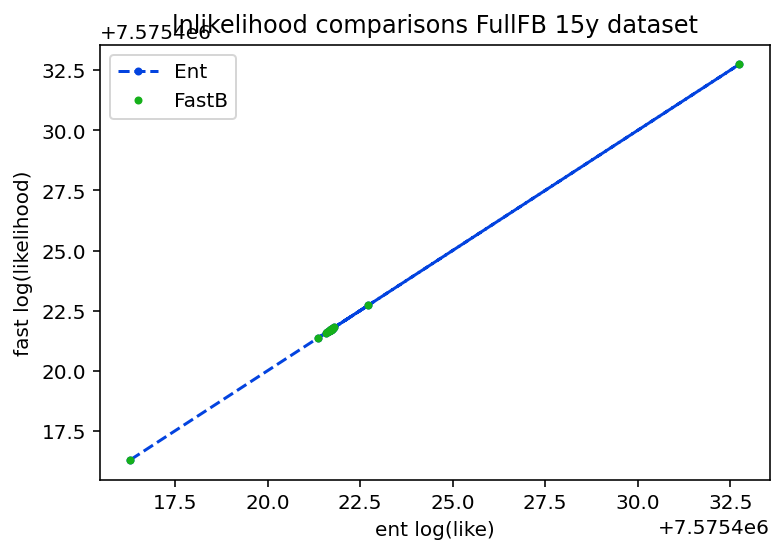

In [27]:
plt.plot(log_L_Ent_15y, log_L_Ent_15y, ls='--', marker='.', color='xkcd:blue', label = 'Ent')
plt.plot(log_L_Ent_15y, log_L_Fast_15y, ls='', marker='.', color='xkcd:green', label = 'FastB')
plt.legend(loc='upper left')
plt.xlabel("ent log(like)")
plt.ylabel("fast log(likelihood)")
plt.title('lnlikelihood comparisons FullFB 15y dataset')
#plt.savefig('/home/reyna/BayesHopperBurst/testing plots/FullFastBurst_15y_lnlikedif.png')

Text(0.5, 1.0, 'val dif for randome samples 15y')

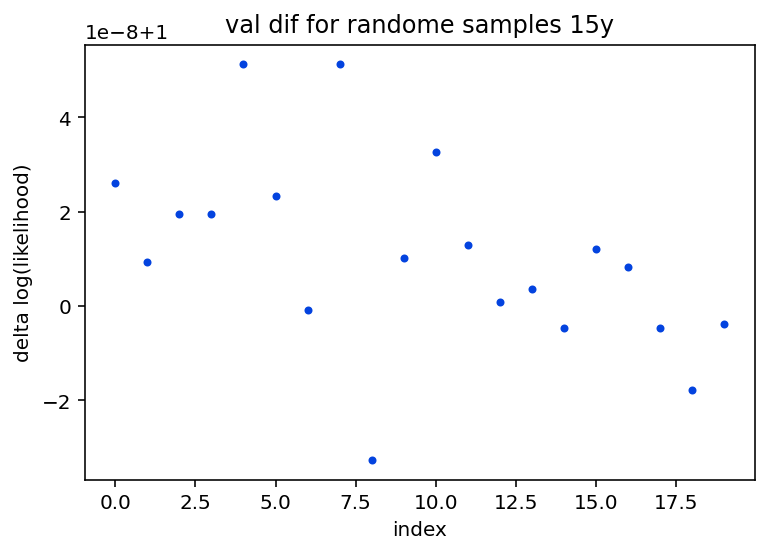

In [28]:
plt.plot(np.exp(log_L_Fast_15y - log_L_Ent_15y), ls='', marker='.', color='xkcd:blue')
#plt.gca().axhline(0.1, ls='--', color='xkcd:green')
plt.xlabel("index")
plt.ylabel("delta log(likelihood)")
plt.title('val dif for randome samples 15y')
#plt.savefig('/home/reyna/BayesHopperBurst/testing plots/FullFastBurst_15y_precentdif.png')

In [121]:
FB_15y = FB.FastBurst(pta = pta, psrs = psrs, params = d0_15y, Npsr = len(psrs), tref=53000*86400, Nglitch = N_glitches, Nwavelet = N_wavelets)

In [123]:
#%%prun
NN = 100

log_L_Ent_15y_shaped = []
log_L_Fast_15y_shaped = []
#amplitudes = []

for n in range(NN):
    #amplitudes.append(i*0.5e-6)
    d0_sample = parameter.sample(pta.params)
    d0_15y = {'Glitch_0_log10_f0': -7.381053872965667,
         'Glitch_0_log10_h': d0_sample['Glitch_0_log10_h'],
         'Glitch_0_phase0': d0_sample['Glitch_0_phase0'],
         'Glitch_0_psr_idx': 38.011596738366116,
         'Glitch_0_t0': 8.543543293559296,
         'Glitch_0_tau': 2.2979795405051506,
         'Glitch_1_log10_f0': -8.000188906431541,
         'Glitch_1_log10_h': d0_sample['Glitch_1_log10_h'],
         'Glitch_1_phase0': d0_sample['Glitch_1_phase0'],
         'Glitch_1_psr_idx': 3.568970889187356,
         'Glitch_1_t0': 4.4969284682672,
         'Glitch_1_tau': 3.870961316921214,
         'Glitch_2_log10_f0': -7.3756025819950475,
         'Glitch_2_log10_h': d0_sample['Glitch_2_log10_h'],
         'Glitch_2_phase0': d0_sample['Glitch_2_phase0'],
         'Glitch_2_psr_idx': 48.94345835351979,
         'Glitch_2_t0': 6.283803062549344,
         'Glitch_2_tau': 3.197059464396122,
         'Glitch_3_log10_f0': -8.31994904230876,
         'Glitch_3_log10_h': d0_sample['Glitch_3_log10_h'],
         'Glitch_3_phase0': d0_sample['Glitch_3_phase0'],
         'Glitch_3_psr_idx': 33.142068869701944,
         'Glitch_3_t0': 4.7591270550245195,
         'Glitch_3_tau': 0.9232166575188985,
         'Glitch_4_log10_f0': -7.365199900056618,
         'Glitch_4_log10_h': d0_sample['Glitch_4_log10_h'],
         'Glitch_4_phase0': d0_sample['Glitch_4_phase0'],
         'Glitch_4_psr_idx': 30.356721284144207,
         'Glitch_4_t0': 8.803472193066767,
         'Glitch_4_tau': 2.6373388106153803,
         'wavelet_0_cos_gwtheta': d0_sample['wavelet_0_cos_gwtheta'],
         'wavelet_0_gw_psi': d0_sample['wavelet_0_gw_psi'],
         'wavelet_0_gwphi': d0_sample['wavelet_0_gwphi'],
         'wavelet_0_log10_f0': -7.5526178776621,
         'wavelet_0_log10_h': d0_sample['wavelet_0_log10_h'],
         'wavelet_0_log10_h_cross': d0_sample['wavelet_0_log10_h_cross'],
         'wavelet_0_phase0': d0_sample['wavelet_0_phase0'],
         'wavelet_0_phase0_cross': d0_sample['wavelet_0_phase0_cross'],
         'wavelet_0_t0': 9.347287310865399,
         'wavelet_0_tau': 3.5547669917713836,
         'wavelet_1_cos_gwtheta': d0_sample['wavelet_1_cos_gwtheta'],
         'wavelet_1_gw_psi': d0_sample['wavelet_1_gw_psi'],
         'wavelet_1_gwphi': d0_sample['wavelet_1_gwphi'],
         'wavelet_1_log10_f0': -7.5526178776621,
         'wavelet_1_log10_h': d0_sample['wavelet_1_log10_h'],
         'wavelet_1_log10_h_cross': d0_sample['wavelet_1_log10_h_cross'],
         'wavelet_1_phase0': d0_sample['wavelet_1_phase0'],
         'wavelet_1_phase0_cross': d0_sample['wavelet_1_phase0_cross'],
         'wavelet_1_t0': 6.5939970174540665,
         'wavelet_1_tau': 3.653058549369535,
         'wavelet_2_cos_gwtheta': d0_sample['wavelet_2_cos_gwtheta'],
         'wavelet_2_gw_psi': d0_sample['wavelet_2_gw_psi'],
         'wavelet_2_gwphi': d0_sample['wavelet_2_gwphi'],
         'wavelet_2_log10_f0': -7.5526178776621,
         'wavelet_2_log10_h': d0_sample['wavelet_2_log10_h'],
         'wavelet_2_log10_h_cross': d0_sample['wavelet_2_log10_h_cross'],
         'wavelet_2_phase0': d0_sample['wavelet_2_phase0'],
         'wavelet_2_phase0_cross': d0_sample['wavelet_2_phase0_cross'],
         'wavelet_2_t0': 0.44878491814705823,
         'wavelet_2_tau': 1.028397080808293,
         'wavelet_3_cos_gwtheta': d0_sample['wavelet_3_cos_gwtheta'],
         'wavelet_3_gw_psi': d0_sample['wavelet_3_gw_psi'],
         'wavelet_3_gwphi': d0_sample['wavelet_3_gwphi'],
         'wavelet_3_log10_f0': -7.5526178776621,
         'wavelet_3_log10_h': d0_sample['wavelet_3_log10_h'],
         'wavelet_3_log10_h_cross': d0_sample['wavelet_3_log10_h_cross'],
         'wavelet_3_phase0': d0_sample['wavelet_3_phase0'],
         'wavelet_3_phase0_cross': d0_sample['wavelet_3_phase0_cross'],
         'wavelet_3_t0': 4.871070880746532,
         'wavelet_3_tau': 2.820987177759732,
         'wavelet_4_cos_gwtheta': d0_sample['wavelet_4_cos_gwtheta'],
         'wavelet_4_gw_psi': d0_sample['wavelet_4_gw_psi'],
         'wavelet_4_gwphi': d0_sample['wavelet_4_gwphi'],
         'wavelet_4_log10_f0': -7.5526178776621,
         'wavelet_4_log10_h': d0_sample['wavelet_4_log10_h'],
         'wavelet_4_log10_h_cross': d0_sample['wavelet_4_log10_h_cross'],
         'wavelet_4_phase0': d0_sample['wavelet_4_phase0'],
         'wavelet_4_phase0_cross': d0_sample['wavelet_4_phase0_cross'],
         'wavelet_4_t0': 5.992563315492056,
         'wavelet_4_tau': 3.7437489504610784}
    x0_15y = np.array([d0_15y[par.name] for par in pta.params])

    
    #log_L_Ent_15y_shaped.append(pta.get_lnlikelihood(x0_15y))
    log_L_Fast_15y_shaped.append(FB_15y.get_lnlikelihood(x0_15y))
    print('run ',n)
    
#log_L_Ent_15y_shaped = np.array(log_L_Ent_15y_shaped)
log_L_Fast_15y_shaped = np.array(log_L_Fast_15y_shaped)

run  0
run  1
run  2
run  3
run  4
run  5
run  6
run  7
run  8
run  9
run  10
run  11
run  12
run  13
run  14
run  15
run  16
run  17
run  18
run  19
run  20
run  21
run  22
run  23
run  24
run  25
run  26
run  27
run  28
run  29
run  30
run  31
run  32
run  33
run  34
run  35
run  36
run  37
run  38
run  39
run  40
run  41
run  42
run  43
run  44
run  45
run  46
run  47
run  48
run  49
run  50
run  51
run  52
run  53
run  54
run  55
run  56
run  57
run  58
run  59
run  60
run  61
run  62
run  63
run  64
run  65
run  66
run  67
run  68
run  69
run  70
run  71
run  72
run  73
run  74
run  75
run  76
run  77
run  78
run  79
run  80
run  81
run  82
run  83
run  84
run  85
run  86
run  87
run  88
run  89
run  90
run  91
run  92
run  93
run  94
run  95
run  96
run  97
run  98
run  99


Text(0.5, 1.0, 'lnlikelihood comparisons FullFB 15y dataset')

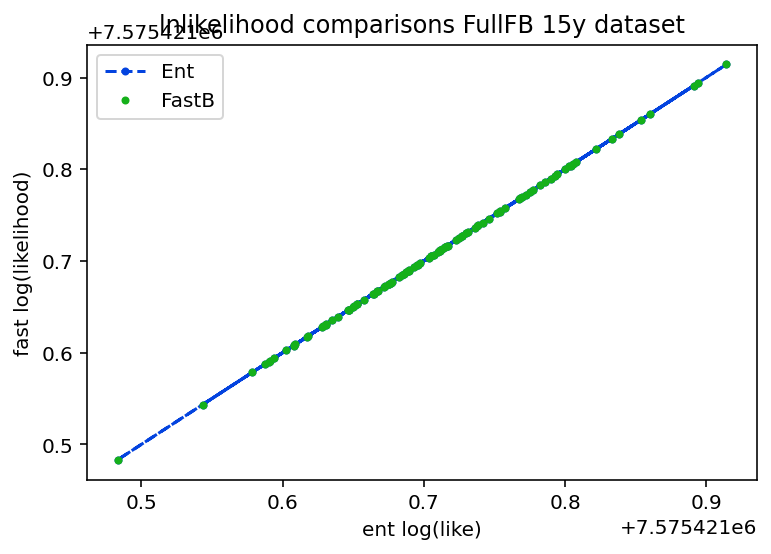

In [118]:
plt.plot(log_L_Ent_15y_shaped, log_L_Ent_15y_shaped, ls='--', marker='.', color='xkcd:blue', label = 'Ent')
plt.plot(log_L_Ent_15y_shaped, log_L_Fast_15y_shaped, ls='', marker='.', color='xkcd:green', label = 'FastB')
plt.legend(loc='upper left')
plt.xlabel("ent log(like)")
plt.ylabel("fast log(likelihood)")
plt.title('lnlikelihood comparisons FullFB 15y dataset')
#plt.savefig('/home/reyna/BayesHopperBurst/testing plots/FullFastBurst_15y_lnlikedif.png')

Text(0.5, 1.0, 'val dif for randome samples 15y')

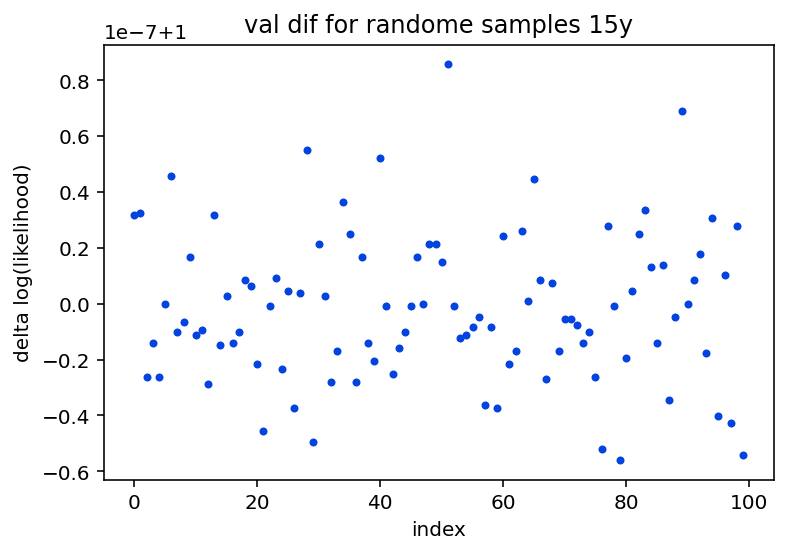

In [119]:
plt.plot(np.exp(log_L_Fast_15y_shaped - log_L_Ent_15y_shaped), ls='', marker='.', color='xkcd:blue')
#plt.gca().axhline(0.1, ls='--', color='xkcd:green')
plt.xlabel("index")
plt.ylabel("delta log(likelihood)")
plt.title('val dif for randome samples 15y')
#plt.savefig('/home/reyna/BayesHopperBurst/testing plots/FullFastBurst_15y_precentdif.png')